In [ ]:
#Import Packages
import numpy
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

def define_gan(g_model, d_model):
	d_model.trainable = False
	model = Sequential()
	model.add(g_model)
	model.add(d_model)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

def load_real_samples():
	(trainX, _), (_, _) = load_data()
	X = expand_dims(trainX, axis=-1)
	X = X.astype('float32')
	X = X / 255.0
	return X

def generate_real_samples(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y

def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = g_model.predict(x_input)
	y = zeros((n_samples, 1))
	return X, y

def save_plot(examples, epoch, n=10):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	save_plot(x_fake, epoch)
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			d_loss, _ = d_model.train_on_batch(X, y)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
11493376/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/234, d=0.689, g=0.709
>1, 2/234, d=0.684, g=0.728


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 3/234, d=0.677, g=0.745
>1, 4/234, d=0.667, g=0.762
>1, 5/234, d=0.659, g=0.781
>1, 6/234, d=0.653, g=0.793
>1, 7/234, d=0.649, g=0.807
>1, 8/234, d=0.642, g=0.821
>1, 9/234, d=0.638, g=0.830
>1, 10/234, d=0.641, g=0.835
>1, 11/234, d=0.636, g=0.831
>1, 12/234, d=0.634, g=0.818
>1, 13/234, d=0.633, g=0.799
>1, 14/234, d=0.636, g=0.781
>1, 15/234, d=0.636, g=0.765
>1, 16/234, d=0.642, g=0.747
>1, 17/234, d=0.637, g=0.733
>1, 18/234, d=0.636, g=0.723
>1, 19/234, d=0.634, g=0.715
>1, 20/234, d=0.624, g=0.710
>1, 21/234, d=0.618, g=0.707
>1, 22/234, d=0.612, g=0.705
>1, 23/234, d=0.603, g=0.704
>1, 24/234, d=0.595, g=0.702
>1, 25/234, d=0.585, g=0.702
>1, 26/234, d=0.572, g=0.703
>1, 27/234, d=0.564, g=0.702
>1, 28/234, d=0.558, g=0.702
>1, 29/234, d=0.544, g=0.703
>1, 30/234, d=0.534, g=0.703
>1, 31/234, d=0.529, g=0.704
>1, 32/234, d=0.510, g=0.704
>1, 33/234, d=0.505, g=0.705
>1, 34/234, d=0.492, g=0.706
>1, 35/234, d=0.478, g=0.707
>1, 36/234, d=0.478, g=0.708
>1, 37/234, d=0.458, 

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


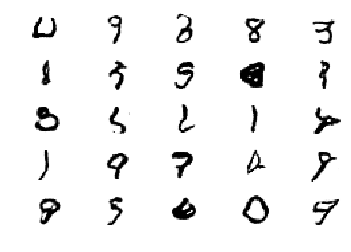

In [ ]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def save_plot(examples, n):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

model = load_model('generator_model_100.h5')
latent_points = generate_latent_points(100, 80)
X = model.predict(latent_points)
save_plot(X, 5)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


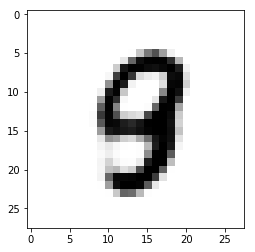

In [ ]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
model = load_model('generator_model_100.h5')
vector = asarray([[0.0 for _ in range(100)]])
X = model.predict(vector)
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()